In [1]:
import torchvision 
import torch.nn as nn 
import torch 
import torch.nn.functional as F 
from torchvision import transforms,models,datasets 
import matplotlib.pyplot as plt 
from PIL import Image 
import numpy as np 
from torch import optim 

from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import seaborn as sns

In [2]:
data_dir = "C:/Users/ENVY/Downloads/dataset/dataset/train_images"

transform = transforms.Compose([transforms.Resize(255), 
    transforms.CenterCrop(224), 
    transforms.RandomHorizontalFlip(),                            
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])]) 

dataset = torchvision.datasets.ImageFolder(data_dir, transform= transform)


In [4]:
# SPLITING DATASET: 80 % TRAINING ,20 % VALIDATION 
train_dataset, val_dataset = random_split(dataset,(110,43))

In [5]:
training_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=32)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=1)

print("Length of the train_loader:", len(training_loader))
print("Length of the val_loader:", len(val_loader))

Length of the train_loader: 4
Length of the val_loader: 43


In [6]:
inputs, classes = next(iter(training_loader))  
inputs.shape,classes.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [7]:

device = torch.device("cuda:0")
if torch.cuda.is_available():
    device = torch.device("cuda:0")  #
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [8]:

# DEFINING MODEL VGG16

model = models.vgg16(pretrained=True).to(device) # freeze all the parameters except the final layer     
for param in model.parameters():
    param.requires_grad = False   
    
classifier = nn.Sequential(
               nn.Linear(25088, 4096),
               nn.ReLU(inplace=True),
               nn.Linear(4096, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 1),
               nn.Sigmoid()).to(device)
model.classifier = classifier
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
img = inputs.to(device)
print(img.shape)
a = model(img)
a.shape

torch.Size([32, 3, 224, 224])


torch.Size([32, 1])

In [10]:
import torch.optim as optim


criterion = nn.BCELoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)



In [12]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)
    
    correct_result_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_result_sum/y_test.shape[0]
    acc  = torch.round(acc*100)
    
    return acc
    

In [13]:
torch.cuda.empty_cache()

In [14]:
# TRAINING THE MODEL
print("Begin training...")

accuracy_stats = {
    'train': [],
    "val": []
             }
loss_stats = {
    'train': [],
    "val": []
             }
Epochs= 19

for epoch in range(Epochs):

    # TRAINING
    
    train_epoch_loss = 0
    train_epoch_acc  = 0
    
    model.train()
    for X_train_batch, y_train_batch in training_loader:
        y_train_batch = y_train_batch.to(torch.float32)
        X_train_batch , y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred  = model(X_train_batch)
        
        train_loss = criterion( y_train_pred,y_train_batch.unsqueeze(1))
        train_acc = binary_acc(y_train_pred,y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION 
    
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
    
        for X_val_batch, y_val_batch in val_loader:
            y_val_batch = y_val_batch.to(torch.float32)
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            #y_val_pred = torch.unsqueeze(y_val_pred, 0)

            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            val_acc = binary_acc(y_val_pred, y_val_batch.unsqueeze(1))

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        
    loss_stats['train'].append(train_epoch_loss/len(training_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(training_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader)) 
            
    print(f"Epoch: {epoch}| train-loss: {train_epoch_loss/len(training_loader)}| val-loss: {val_epoch_loss/len(val_loader)} | train_accuracy : {train_epoch_acc/len(training_loader)} | val_accuracy : {val_epoch_acc/len(val_loader)} ")
      

Begin training...
Epoch: 0| train-loss: 1.5248943567276| val-loss: 0.42408196099622303 | train_accuracy : 59.0 | val_accuracy : 83.72093023255815 
Epoch: 1| train-loss: 0.2187842670828104| val-loss: 0.05597782549913581 | train_accuracy : 96.0 | val_accuracy : 97.67441860465117 
Epoch: 2| train-loss: 0.04073968200827949| val-loss: 0.013175102959423363 | train_accuracy : 99.25 | val_accuracy : 100.0 
Epoch: 3| train-loss: 0.010516111564356834| val-loss: 0.05101923278205896 | train_accuracy : 99.25 | val_accuracy : 97.67441860465117 
Epoch: 4| train-loss: 0.02135911344521446| val-loss: 0.0022063435094360974 | train_accuracy : 99.25 | val_accuracy : 100.0 
Epoch: 5| train-loss: 0.00019100708050245885| val-loss: 0.001319958858243676 | train_accuracy : 100.0 | val_accuracy : 100.0 
Epoch: 6| train-loss: 0.00022542470560438232| val-loss: 0.001967463315375936 | train_accuracy : 100.0 | val_accuracy : 100.0 
Epoch: 7| train-loss: 0.0003132557303615613| val-loss: 0.00395539372826589 | train_accu

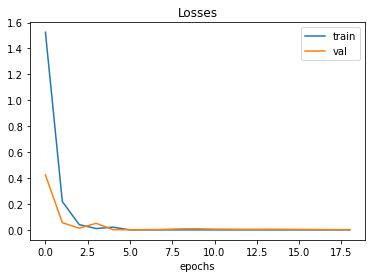

In [15]:
# PLOTTING THE LOSSES
for v,c in sorted(loss_stats.items()):
    plt.plot(c,label=v)
plt.xlabel('epochs')
plt.title('Losses')
plt.legend()
plt.show()
#plt.plot(loss)

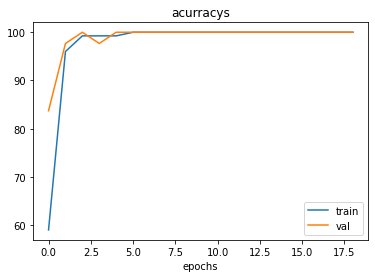

In [16]:
# PLOTTING THE ACCURACIES
for v,c in sorted(accuracy_stats.items()):
    plt.plot(c,label=v)
plt.xlabel('epochs')
plt.title('acurracys')
plt.legend()
plt.show()

In [17]:
torch.save(model.state_dict(), 'reda_vgg16_transferlearning.pth')

In [18]:
model.load_state_dict(torch.load('reda_vgg16_transferlearning.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
# PREPARING TESTING DATA
data_dir = "C:/Users/ENVY/Downloads/dataset/dataset/test_images"


transforms2 = transforms.Compose([transforms.Resize((224,224)),
                                  
                                  transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])
                                                           ])

dataset2 =datasets.ImageFolder(data_dir, transform= transforms2)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1 ,shuffle=True) 

In [20]:
print(len(test_loader))
dataset2.class_to_idx

10


{'fields': 0, 'roads': 1}

In [21]:
# TESTING
y_true =[]
y_predicted = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x,batch_y = batch_x.to(device),batch_y.to(device)
        
        y_test_pred = model(batch_x)
        y_pred_tag = torch.round(y_test_pred)
        
       
        y_predicted.append(y_pred_tag.cpu().numpy())
        y_true.append(batch_y.cpu().numpy())

In [22]:
y_predicted = np.array(y_predicted)
y_predicted = y_predicted.reshape(10,)

y_true =  np.array(y_true)
y_true = y_true.reshape(10,)



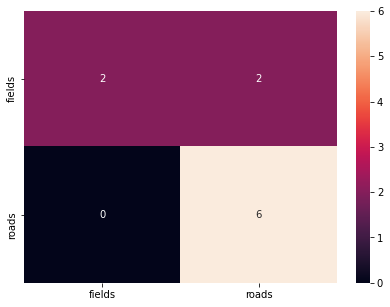

In [23]:
# PLOTTING HEATMAP OF THE CONFUSION MATRIX
from sklearn.metrics import confusion_matrix, classification_report
idx2class = {v: k for k, v in dataset2.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_predicted)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

In [24]:
# PLOTTING THE CLASSIFICATION REPORT
print(classification_report(y_predicted, y_true))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         2
         1.0       1.00      0.75      0.86         8

    accuracy                           0.80        10
   macro avg       0.75      0.88      0.76        10
weighted avg       0.90      0.80      0.82        10



Text(0, 0.5, 'True Positive Rate')

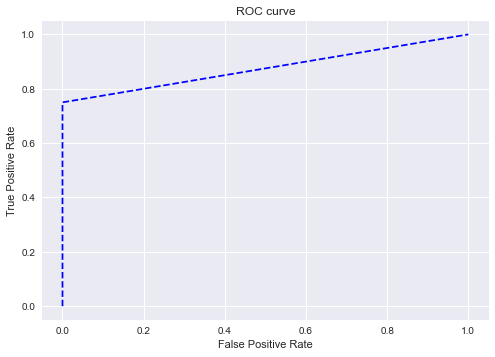

In [25]:
# PLOTTING THE ROC CURVE
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_predicted,y_true, pos_label = 1)

import matplotlib.pyplot as plt 
plt.style.use('seaborn')

plt.plot(fpr,tpr,  linestyle = '--', color = 'blue', label = 'VGG16')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')